In [ ]:
pip install cudaq lime shap

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.5/117.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.9/156.9 MB 7.9 MB/s eta 0:00:00
  Created wheel for cudaq: filename=cudaq-0.9.1-py3-none-any.whl size=6787 sha256=eec4ed2523fcd6440bf2d14b1f177a48c650f446775d44388cd60b80a7ec9723
  Stored in directory: /root/.cache/pip/wheels/

In [ ]:
!pip install matplotlib==3.8.4
!pip install torch==2.2.2
!pip install torchvision==0.17.0
!pip install scikit-learn==1.4.2

  Using cached torch-2.2.2-cp310-cp310-manylinux1_x86_64.whl.metadata (26 kB)
Using cached torch-2.2.2-cp310-cp310-manylinux1_x86_64.whl (755.5 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.2.0
    Uninstalling torch-2.2.0:
      Successfully uninstalled torch-2.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.5.1+cu121 requires torch==2.5.1, but you have torch 2.2.2 which is incompatible.
torchvision 0.17.0 requires torch==2.2.0, but you have torch 2.2.2 which is incompatible.
  Using cached torch-2.2.0-cp310-cp310-manylinux1_x86_64.whl.metadata (25 kB)
Using cached torch-2.2.0-cp310-cp310-manylinux1_x86_64.whl (755.5 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.2.2
    Uninstalling torch-2.2.2:
      Successfully uninstalled torch-2.2.2
ERROR: pip's dependency resolver does not current

In [ ]:
import cudaq
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Function
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import shap
from lime.lime_tabular import LimeTabularExplainer

In [ ]:
device = torch.device('cpu')
cudaq.set_target("qpp-cpu")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def ry(theta, qubit):
    cudaq.ry(theta, qubit)

def rx(theta, qubit):
    cudaq.rx(theta, qubit)

In [ ]:
class QuantumFunction(Function):
    def __init__(self, qubit_count: int, hamiltonian: cudaq.SpinOperator):
        @cudaq.kernel
        def kernel(qubit_count: int, thetas: np.ndarray):
            qubits = cudaq.qvector(qubit_count)
            ry(thetas[0], qubits[0])
            rx(thetas[1], qubits[0])
        self.kernel = kernel
        self.qubit_count = qubit_count
        self.hamiltonian = hamiltonian

    def run(self, theta_vals: torch.Tensor) -> torch.Tensor:
        theta_vals_np = theta_vals.cpu().numpy()
        qubit_count_list = [self.qubit_count for _ in range(theta_vals_np.shape[0])]
        results = cudaq.observe(self.kernel, self.hamiltonian, qubit_count_list, theta_vals_np)
        exp_vals = [results[i].expectation() for i in range(len(results))]
        return torch.Tensor(exp_vals).to(device)

    @staticmethod
    def forward(ctx, thetas: torch.Tensor, quantum_circuit, shift) -> torch.Tensor:
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit
        exp_vals = ctx.quantum_circuit.run(thetas).reshape(-1, 1)
        ctx.save_for_backward(thetas, exp_vals)
        return exp_vals

    @staticmethod
    def backward(ctx, grad_output):
        thetas, _ = ctx.saved_tensors
        gradients = torch.zeros(thetas.shape, device=device)
        for i in range(thetas.shape[1]):
            thetas_plus = thetas.clone()
            thetas_plus[:, i] += ctx.shift
            exp_vals_plus = ctx.quantum_circuit.run(thetas_plus)

            thetas_minus = thetas.clone()
            thetas_minus[:, i] -= ctx.shift
            exp_vals_minus = ctx.quantum_circuit.run(thetas_minus)

            gradients[:, i] = (exp_vals_plus - exp_vals_minus) / (2 * ctx.shift)

        return gradients * grad_output, None, None

In [ ]:
class QuantumLayer(nn.Module):
    def __init__(self, qubit_count: int, hamiltonian, shift: torch.Tensor):
        super(QuantumLayer, self).__init__()
        self.quantum_circuit = QuantumFunction(qubit_count, hamiltonian)
        self.shift = shift

    def forward(self, input: torch.Tensor):
        return QuantumFunction.apply(input, self.quantum_circuit, self.shift)


In [ ]:
class Hybrid_QNN(nn.Module):
    def __init__(self, input_dim=8):
        super(Hybrid_QNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.25)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 2)
        self.dropout = nn.Dropout(0.25)
        self.quantum = QuantumLayer(qubit_count=2,
                                    hamiltonian=cudaq.spin.z(0),
                                    shift=torch.tensor(torch.pi / 2))

    def forward(self, x: torch.Tensor):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.dropout(x)
        # Pass final 2-dim vector into quantum layer
        return torch.sigmoid(self.quantum(x)).view(-1)

In [ ]:
def load_data(path):
    data = pd.read_csv(path)
    return data

dataset_path = "/content/tablea1.csv"
data = load_data(dataset_path)

numeric_cols = data.select_dtypes(include=[np.number]).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

features = ['logM1/2', 'logRe', 'logAge', '[Z/H]', 'logM*/L',
            'DlogAge', 'D[Z/H]', 'DlogM*/L']
target = 'logsigmae'

# We'll combine features + target => 9 columns total
all_cols = features + [target]
df_data = data[all_cols].copy().dropna()

In [ ]:
# Hyperparams for the GAN
latent_dim = 16
hidden_dim = 64
num_epochs_gan = 200
batch_size = 64
learning_rate = 0.0002

# Prepare real data as a Torch tensor
real_data_all = torch.tensor(df_data.values, dtype=torch.float32).to(device)

# MinMax scale each column in [0,1] for stable GAN training
scaler_gan = MinMaxScaler()
real_data_all_scaled = scaler_gan.fit_transform(df_data.values)
real_data_all_scaled = torch.tensor(real_data_all_scaled, dtype=torch.float32).to(device)


class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim=9, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, hidden_dim*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim*2, hidden_dim*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim*4, output_dim),
            nn.Sigmoid()  # Output in [0,1]
        )

    def forward(self, z):
        return self.net(z)


class Discriminator(nn.Module):
    def __init__(self, input_dim=9, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim*4, hidden_dim*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()  # Probability of "real"
        )

    def forward(self, x):
        return self.net(x)


# Initialize the GAN
G = Generator(latent_dim=latent_dim, output_dim=9, hidden_dim=hidden_dim).to(device)
D = Discriminator(input_dim=9, hidden_dim=hidden_dim).to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=learning_rate, betas=(0.5, 0.999))


# Helper function to get random noise
def get_noise(n_samples, latent_dim):
    return torch.randn(n_samples, latent_dim, device=device)


# Training loop
losses_g = []
losses_d = []

dataset_size = real_data_all_scaled.size(0)
indices = np.arange(dataset_size)

print("Starting GAN training...")
for epoch in range(num_epochs_gan):
    np.random.shuffle(indices)
    # Batches
    batch_losses_g = []
    batch_losses_d = []
    for start_idx in range(0, dataset_size, batch_size):
        end_idx = start_idx + batch_size
        batch_indices = indices[start_idx:end_idx]

        real_batch = real_data_all_scaled[batch_indices]
        cur_bs = real_batch.size(0)

        # -----------------
        #  Train Discriminator
        # -----------------
        z = get_noise(cur_bs, latent_dim)
        fake_batch = G(z)

        # Real labels = 1, Fake labels = 0
        real_labels = torch.ones(cur_bs, 1, device=device)
        fake_labels = torch.zeros(cur_bs, 1, device=device)

        # Discriminator on real
        D_real = D(real_batch)
        D_real_loss = criterion(D_real, real_labels)

        # Discriminator on fake
        D_fake = D(fake_batch.detach())
        D_fake_loss = criterion(D_fake, fake_labels)

        D_loss = D_real_loss + D_fake_loss
        optimizer_D.zero_grad()
        D_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------
        # Goal: fool the Discriminator => label=1
        D_fake_for_G = D(fake_batch)
        G_loss = criterion(D_fake_for_G, real_labels)

        optimizer_G.zero_grad()
        G_loss.backward()
        optimizer_G.step()

        batch_losses_g.append(G_loss.item())
        batch_losses_d.append(D_loss.item())

    # End of epoch
    epoch_loss_g = np.mean(batch_losses_g)
    epoch_loss_d = np.mean(batch_losses_d)
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs_gan}]  "
              f"D_loss: {epoch_loss_d:.4f}  G_loss: {epoch_loss_g:.4f}")

print("GAN training complete.")

Starting GAN training...
Epoch [1/200]  D_loss: 1.3786  G_loss: 0.6854
Epoch [10/200]  D_loss: 1.3671  G_loss: 0.7230
Epoch [20/200]  D_loss: 1.3789  G_loss: 0.7354
Epoch [30/200]  D_loss: 1.3956  G_loss: 0.6872
Epoch [40/200]  D_loss: 1.3744  G_loss: 0.7138
Epoch [50/200]  D_loss: 1.3639  G_loss: 0.7069
Epoch [60/200]  D_loss: 1.3718  G_loss: 0.7211
Epoch [70/200]  D_loss: 1.3836  G_loss: 0.7144
Epoch [80/200]  D_loss: 1.3706  G_loss: 0.7146
Epoch [90/200]  D_loss: 1.3796  G_loss: 0.7058
Epoch [100/200]  D_loss: 1.3737  G_loss: 0.7132
Epoch [110/200]  D_loss: 1.3725  G_loss: 0.7253
Epoch [120/200]  D_loss: 1.3809  G_loss: 0.7080
Epoch [130/200]  D_loss: 1.3802  G_loss: 0.6993
Epoch [140/200]  D_loss: 1.3847  G_loss: 0.7058
Epoch [150/200]  D_loss: 1.3905  G_loss: 0.6930
Epoch [160/200]  D_loss: 1.3825  G_loss: 0.7074
Epoch [170/200]  D_loss: 1.3864  G_loss: 0.6999
Epoch [180/200]  D_loss: 1.3862  G_loss: 0.6965
Epoch [190/200]  D_loss: 1.3860  G_loss: 0.6939
Epoch [200/200]  D_loss: 1

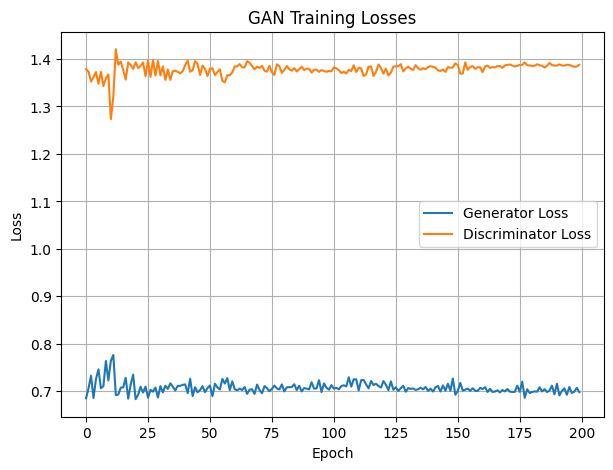

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(losses_g, label="Generator Loss")
plt.plot(losses_d, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GAN Training Losses")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
n_synthetic = real_data_all_scaled.shape[0]  # Generate as many as original
z = get_noise(n_synthetic, latent_dim)
with torch.no_grad():
    synthetic_scaled = G(z).cpu().numpy()

# Reverse MinMax scaling to get back to original range
synthetic_data_9d = scaler_gan.inverse_transform(synthetic_scaled)

# Turn into DataFrame with the original column names
df_synth = pd.DataFrame(synthetic_data_9d, columns=all_cols)

print("\nSample of Synthetic Data:")
display(df_synth.head())


Sample of Synthetic Data:


,logM1/2,logRe,logAge,[Z/H],logM*/L,DlogAge,D[Z/H],DlogM*/L,logsigmae
0,9.168049,0.242178,9.112257,-0.819485,0.175279,-0.091697,-0.094425,0.051076,1.519756
1,11.480649,1.147182,9.666757,-0.100562,0.559669,-0.330864,-0.151577,-0.222239,2.353843
2,11.025196,0.743980,9.745848,-0.049327,0.651620,-0.129031,-0.147948,-0.137667,2.335839
3,10.908922,0.800526,9.700805,-0.049186,0.589349,-0.053393,-0.240516,-0.105627,2.262719
4,11.327110,0.947412,9.734509,0.019158,0.604974,-0.294814,0.094787,-0.190433,2.394460


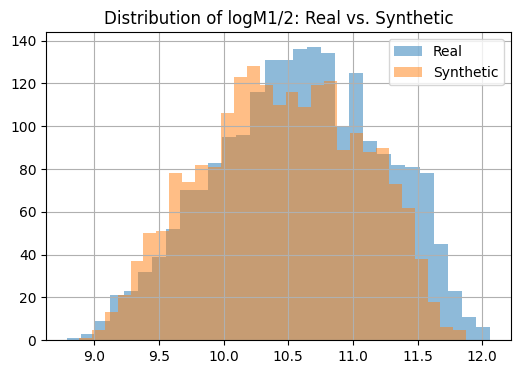

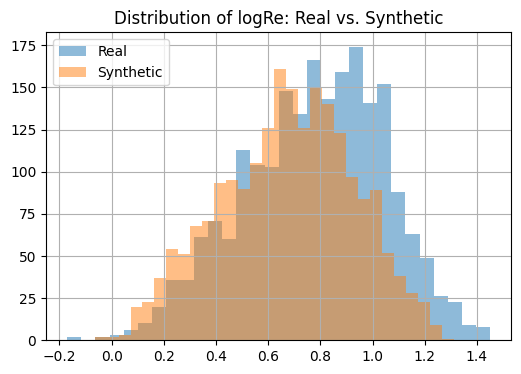

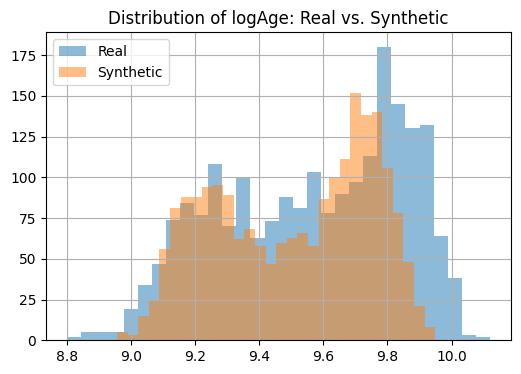

In [ ]:
for col in all_cols[:3]:
    plt.figure(figsize=(6,4))
    plt.hist(df_data[col], bins=30, alpha=0.5, label="Real")
    plt.hist(df_synth[col], bins=30, alpha=0.5, label="Synthetic")
    plt.title(f"Distribution of {col}: Real vs. Synthetic")
    plt.legend()
    plt.grid(True)
    plt.show()


Training Hybrid QNN on Synthetic Data...
Epoch 1/50, Loss: 0.078952, Std Dev: 0.000000
Epoch 2/50, Loss: 0.078841, Std Dev: 0.000055
Epoch 3/50, Loss: 0.078706, Std Dev: 0.000100
Epoch 4/50, Loss: 0.078531, Std Dev: 0.000157
Epoch 5/50, Loss: 0.078391, Std Dev: 0.000203
Epoch 6/50, Loss: 0.078185, Std Dev: 0.000263
Epoch 7/50, Loss: 0.077955, Std Dev: 0.000332
Epoch 8/50, Loss: 0.077558, Std Dev: 0.000442
Epoch 9/50, Loss: 0.077041, Std Dev: 0.000594
Epoch 10/50, Loss: 0.076491, Std Dev: 0.000770
Epoch 11/50, Loss: 0.075663, Std Dev: 0.001008
Epoch 12/50, Loss: 0.074559, Std Dev: 0.001326
Epoch 13/50, Loss: 0.073271, Std Dev: 0.001713
Epoch 14/50, Loss: 0.071616, Std Dev: 0.002197
Epoch 15/50, Loss: 0.070080, Std Dev: 0.002711
Epoch 16/50, Loss: 0.068007, Std Dev: 0.003317
Epoch 17/50, Loss: 0.065824, Std Dev: 0.003992
Epoch 18/50, Loss: 0.063840, Std Dev: 0.004681
Epoch 19/50, Loss: 0.063302, Std Dev: 0.005213
Epoch 20/50, Loss: 0.063219, Std Dev: 0.005602
Epoch 21/50, Loss: 0.062570

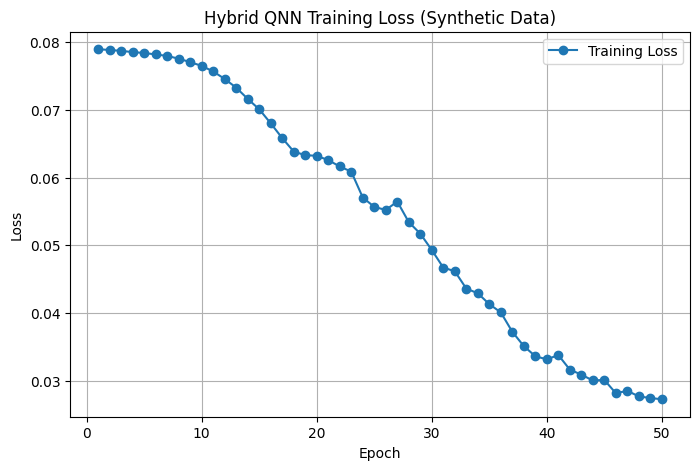

In [ ]:
df_synth = df_synth.dropna()  # just in case
X_synth = df_synth[features].values
y_synth = df_synth[target].values

# Scale X and y
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_synth = scaler_X.fit_transform(X_synth)
y_synth = scaler_y.fit_transform(y_synth.reshape(-1, 1)).flatten()

# Convert to Torch
X_synth = torch.tensor(X_synth, dtype=torch.float32).to(device)
y_synth = torch.tensor(y_synth, dtype=torch.float32).to(device)

# Train-test split
X_train_syn, X_test_syn, y_train_syn, y_test_syn = train_test_split(
    X_synth, y_synth, test_size=0.2, random_state=42
)

# Create the Hybrid QNN
model = Hybrid_QNN(input_dim=len(features)).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.MSELoss().to(device)

epochs = 50
losses = []

print("\nTraining Hybrid QNN on Synthetic Data...")
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    y_hat_train = model(X_train_syn)
    loss = loss_function(y_hat_train, y_train_syn)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    std_loss = np.std(losses)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.6f}, Std Dev: {std_loss:.6f}")

# Plot QNN training loss on synthetic data
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), losses, marker='o', label='Training Loss')
plt.title('Hybrid QNN Training Loss (Synthetic Data)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    y_hat_test = model(X_test_syn)
    test_loss = loss_function(y_hat_test, y_test_syn).item()

r2_score_value = r2_score(y_test_syn.cpu(), y_hat_test.cpu())
mae_score_value = mean_absolute_error(y_test_syn.cpu(), y_hat_test.cpu())
rmse_score_value = np.sqrt(mean_squared_error(y_test_syn.cpu(), y_hat_test.cpu()))
mse_score_value = mean_squared_error(y_test_syn.cpu(), y_hat_test.cpu())

y_max = torch.max(y_synth.cpu()).item()
y_min = torch.min(y_synth.cpu()).item()
alpha = y_max - y_min

mae_accuracy = (1 - mae_score_value / alpha ) * 100
rmse_accuracy = (1 - rmse_score_value / alpha) * 100
mse_accuracy = (1 - mse_score_value / alpha) * 100

print(f"\n--- Evaluation Metrics on Synthetic Data ---")
print(f"Test Loss (MSE)  : {test_loss:.4f}")
print(f"R^2 Score        : {r2_score_value:.4f}")
print(f"MAE              : {mae_score_value:.4f},  (Accuracy by error: {mae_accuracy:.2f}%)")
print(f"RMSE             : {rmse_score_value:.4f}, (Accuracy by error: {rmse_accuracy:.2f}%)")
print(f"MSE              : {mse_score_value:.4f}, (Accuracy by error: {mse_accuracy:.2f}%)")


--- Evaluation Metrics on Synthetic Data ---
Test Loss (MSE)  : 0.0190
R^2 Score        : 0.6409
MAE              : 0.1100,  (Accuracy by error: 89.00%)
RMSE             : 0.1377, (Accuracy by error: 86.23%)
MSE              : 0.0190, (Accuracy by error: 98.10%)


ExactExplainer explainer: 6it [00:32,  6.57s/it]



--- SHAP Summary Plot (Synthetic Data) ---


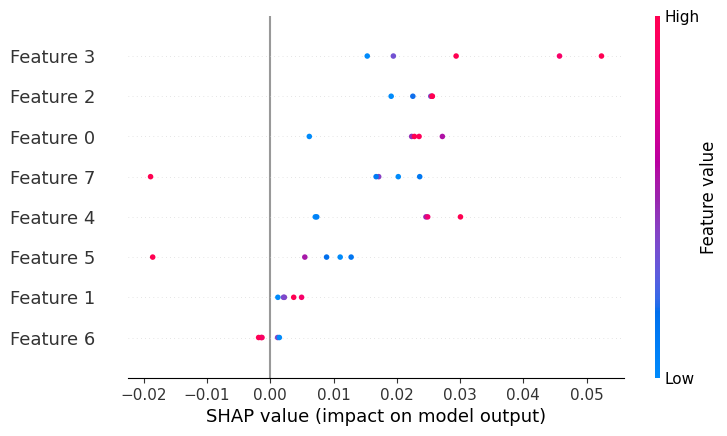

In [ ]:
def model_predict(data_array):
    with torch.no_grad():
        inputs = torch.tensor(data_array, dtype=torch.float32).to(device)
        preds = model(inputs).cpu().numpy()
    return preds

X_train_np = X_train_syn.cpu().numpy()
explainer_shap = shap.Explainer(model_predict, X_train_np)

X_test_np = X_test_syn.cpu().numpy()[:5]
shap_values = explainer_shap(X_test_np)

print("\n--- SHAP Summary Plot (Synthetic Data) ---")
shap.plots.beeswarm(shap_values, max_display=len(features))

In [ ]:
lime_explainer = LimeTabularExplainer(
    training_data=X_train_np,
    feature_names=features,
    discretize_continuous=True,
    mode='regression'
)

instance_idx = 0
instance = X_test_np[instance_idx]
lime_exp = lime_explainer.explain_instance(
    data_row=instance,
    predict_fn=model_predict,
    num_features=len(features)
)

lime_exp.show_in_notebook(show_table=True)